In [2]:
import pandas as pd
import os

In [3]:
path = r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\Datos_Proyecto"

CHECK FOR NA VALUES ON DATA

In [4]:
for csv in os.listdir(path):
    df = pd.read_csv(os.path.join(path, csv)) 
    print(f"{csv}:\n{df.isna().sum()}\n")

cloudiness.csv:
cloudiness       0
cloudiness_id    0
dtype: int64

dates.csv:
date       0
date_id    0
dtype: int64

observations.csv:
date_id               0
precipitation      2500
temp_max           2500
temp_min           2500
wind               2500
humidity              0
pressure              0
solar_radiation       0
visibility            0
weather_id            0
cloudiness_id         0
estacion_id           0
dtype: int64

seasons.csv:
estacion       0
estacion_id    0
dtype: int64

weather.csv:
weather       0
weather_id    0
dtype: int64



In [5]:
for csv in os.listdir(path):
    df = pd.read_csv(os.path.join(path, csv)) 
    print(f"{csv}:\n{df.info()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cloudiness     3 non-null      object
 1   cloudiness_id  3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 180.0+ bytes
cloudiness.csv:
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     25000 non-null  object
 1   date_id  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
dates.csv:
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_id          25000 non-null  int64  
 1   precipitation    22500 non-null  float64
 2   temp_max         22500 non-n

REPLACE THE NA VALUES FROM THE COLUMN precipitation FOR THE MEAN VALUE FORM THE SAME DATE IN OTHER YEARS 

In [6]:
df_observations = pd.read_csv(os.path.join(path, "observations.csv"))
df_dates = pd.read_csv(os.path.join(path, "dates.csv"))

def fill_nan_values(row, column_name):
    if pd.isna(row[column_name]):
        # Get the corresponding date using the date_id
        date_value = df_dates.loc[df_dates['date_id'] == row['date_id'], 'date'].values

        if date_value.size > 0:
            date_str = date_value[0]  # Extract the date string
            month_day = date_str[5:10]  # Get the month and day
            
            # Find dates with the same month and day
            same_days_dates = df_dates[df_dates['date'].str[5:10] == month_day]
            
            # Filter observations based on these date_ids
            observations_filtered = df_observations[df_observations['date_id'].isin(same_days_dates['date_id'])]
            
            # Calculate the mean for the specified column
            mean_value = observations_filtered[column_name].mean()
            return mean_value

    return row[column_name]  # Return the original value if not NaN

In [7]:
# List of columns to fill NaN values
columns_to_fill = ['precipitation', 'temp_max', 'temp_min', 'wind']

# Apply the fill_nan_values function to each specified column
for col in columns_to_fill:
    df_observations[col] = df_observations.apply(fill_nan_values, axis=1, column_name=col)

In [8]:
df_observations.isna().sum()

date_id            0
precipitation      0
temp_max           0
temp_min           0
wind               0
humidity           0
pressure           0
solar_radiation    0
visibility         0
weather_id         0
cloudiness_id      0
estacion_id        0
dtype: int64

In [ ]:
df_observations.to_csv(r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\Datos_Proyecto\observations_lleno.csv",sep=",",index=False, encoding='utf-8')

CREAR LA BDD

In [33]:
import sqlite3

conn = sqlite3.connect(r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\weather.db")
cursor = conn.cursor()

In [34]:

cursor.execute("""
    CREATE TABLE IF NOT EXISTS cloudiness (
        cloudiness TEXT NOT NULL,
        cloudiness_id INTEGER PRIMARY KEY
    )
""")

In [35]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS dates (
        date TEXT NOT NULL,
        date_id INTEGER PRIMARY KEY
    )

""")

In [36]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS weather (
        weather TEXT NOT NULL,
        weather_id INTEGER PRIMARY KEY
    )

""")


In [37]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS seasons (
        estacion TEXT NOT NULL,
        estacion_id INTEGER PRIMARY KEY
    )

""")

In [38]:


cursor.execute("""
    CREATE TABLE IF NOT EXISTS observations (
        date_id INTEGER NOT NULL,
        precipitation REAL,
        temp_max REAL,
        temp_min REAL,
        wind REAL,
        humidity REAL NOT NULL,
        pressure REAL NOT NULL,
        solar_radiation REAL NOT NULL,
        visibility REAL NOT NULL,
        weather_id INTEGER NOT NULL,
        cloudiness_id INTEGER NOT NULL,
        estacion_id INTEGER NOT NULL,
        PRIMARY KEY (date_id, weather_id, cloudiness_id, estacion_id),
        FOREIGN KEY (date_id) REFERENCES dates(date_id),
        FOREIGN KEY (weather_id) REFERENCES weather(weather_id),
        FOREIGN KEY (cloudiness_id) REFERENCES cloudiness(cloudiness_id),
        FOREIGN KEY (estacion_id) REFERENCES seasons(estacion_id)
    )
""")

INSERTAR DATOS

In [39]:
for csv in os.listdir(path):
    df = pd.read_csv(os.path.join(path, csv)) 
    df.to_sql(csv.split(".")[0], conn, if_exists='replace', index=False)

**CARGAR LOS DATOS SQL Y CREAR LOS GRAFICOS**

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar cada tabla en un DataFrame de pandas
df_cloudiness = pd.read_sql_query("SELECT * FROM cloudiness", conn)
df_dates = pd.read_sql_query("SELECT * FROM dates", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_weather = pd.read_sql_query("SELECT * FROM weather", conn)
df_seasons = pd.read_sql_query("SELECT * FROM seasons", conn)

# Cerrar la conexión cuando hayas terminado
conn.close()

# Unir las tablas usando merge
df = df_observations \
    .merge(df_dates, on='date_id') \
    .merge(df_weather, on='weather_id') \
    .merge(df_cloudiness, on='cloudiness_id') \
    .merge(df_seasons, on='estacion_id')


DISTRIBUCIÓN DE LAS TEMPERATURAS MAXIMAS

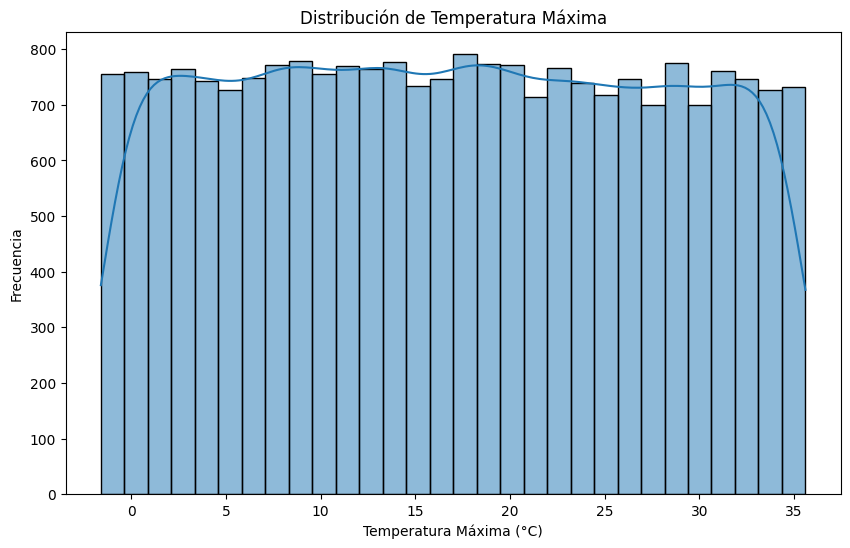

In [41]:
# Graficar un histograma de temperatura máxima
plt.figure(figsize=(10, 6))
sns.histplot(df['temp_max'].dropna(), bins=30, kde=True)
plt.title("Distribución de Temperatura Máxima")
plt.xlabel("Temperatura Máxima (°C)")
plt.ylabel("Frecuencia")
plt.show()

TEMPERATURA MAX/MIN POR FECHA

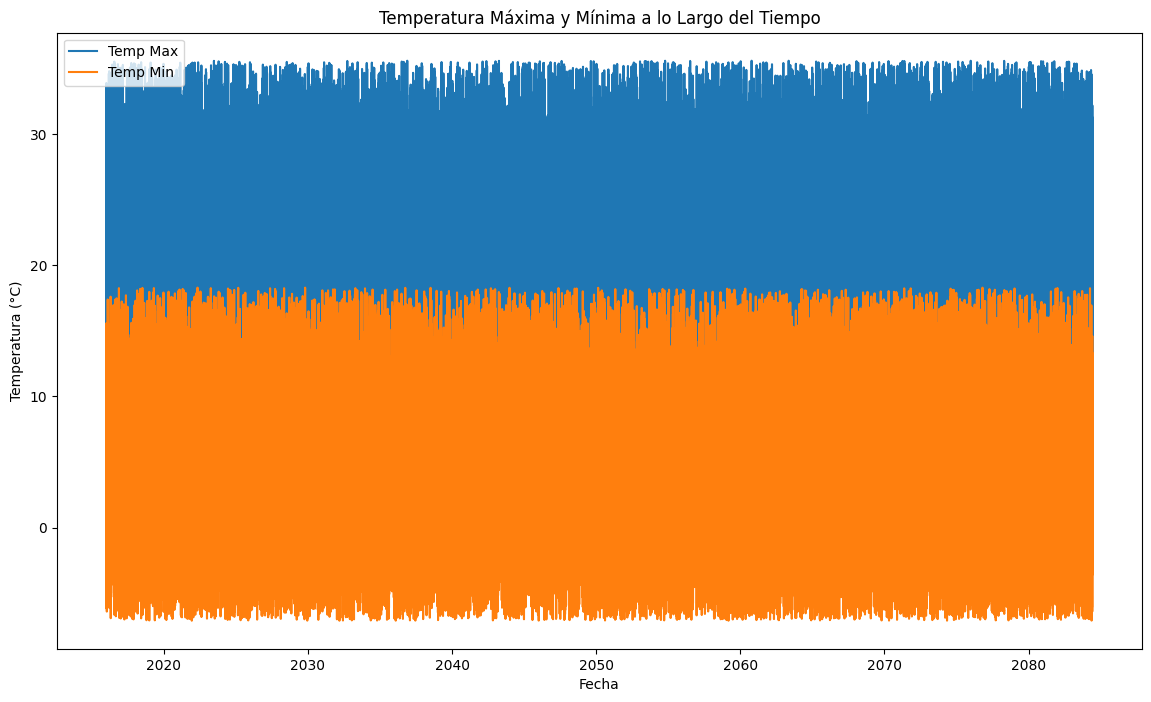

In [50]:
# Convertir la columna de fechas a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Graficar temperatura máxima y mínima a lo largo del tiempo
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='temp_max', data=df, label='Temp Max')
sns.lineplot(x='date', y='temp_min', data=df, label='Temp Min')
plt.title("Temperatura Máxima y Mínima a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

HUMEDAD POR CONDICION CLIMATICA

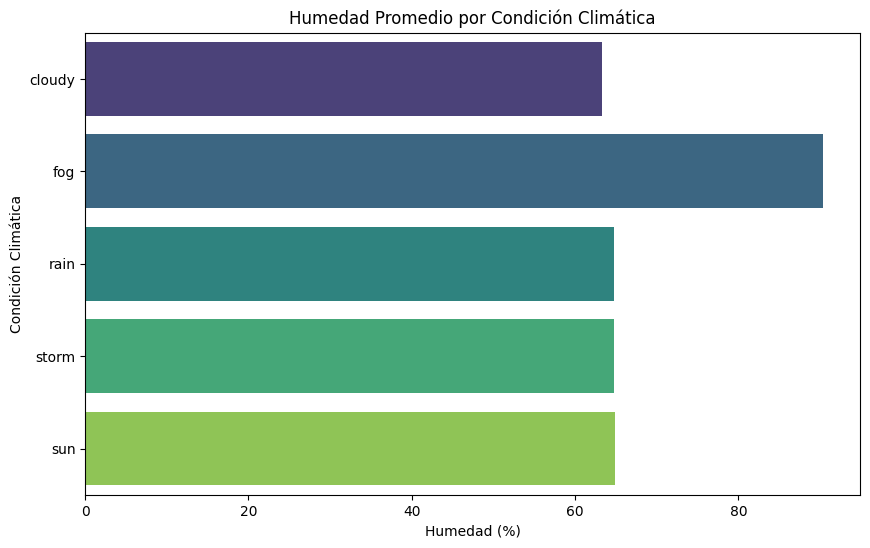

In [43]:
# Calcular la humedad promedio por tipo de clima
df_weather_humidity = df.groupby('weather')['humidity'].mean().reset_index()

# Graficar la humedad promedio por tipo de clima
plt.figure(figsize=(10, 6))
sns.barplot(x='humidity', y='weather', hue='weather', data=df_weather_humidity, palette="viridis", legend=False)
plt.title("Humedad Promedio por Condición Climática")
plt.xlabel("Humedad (%)")
plt.ylabel("Condición Climática")
plt.show()

TEMPERATURA MÁXIMA POR TIPO DE TIEMPO

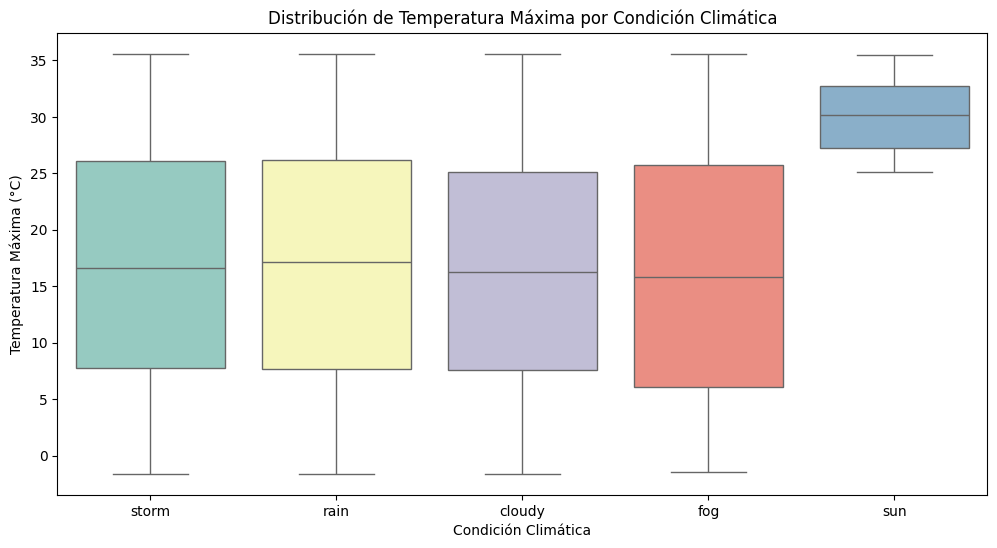

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='temp_max', hue='weather', data=df, palette="Set3", legend=False)
plt.title("Distribución de Temperatura Máxima por Condición Climática")
plt.xlabel("Condición Climática")
plt.ylabel("Temperatura Máxima (°C)")
plt.show()

VIENTO vs PRESIÓN

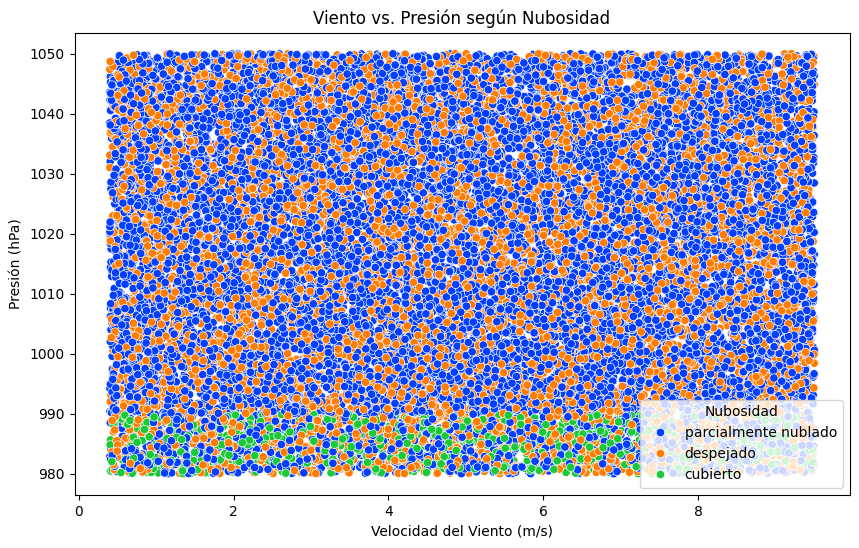

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind', y='pressure', hue='cloudiness', data=df, palette="bright")
plt.title("Viento vs. Presión según Nubosidad")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Presión (hPa)")
plt.legend(title="Nubosidad")
plt.show()

PRECIPITACION POR VIENTO Y TIPO DE TIEMPO

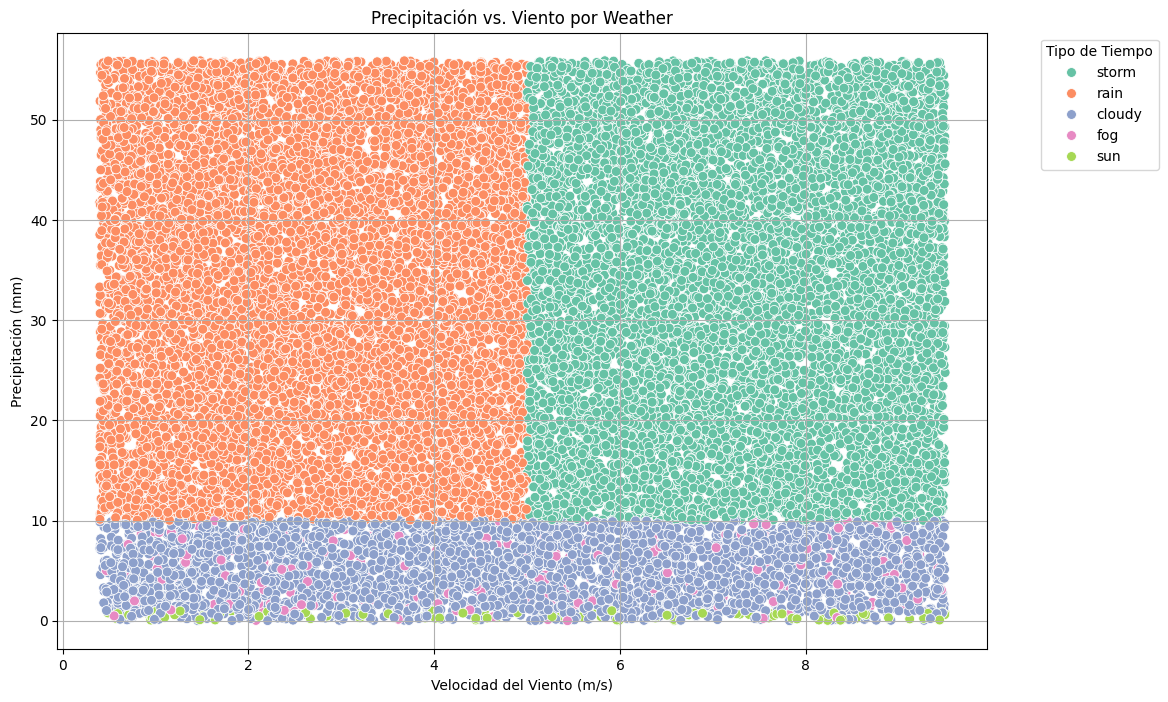

In [46]:
# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(x='wind', y='precipitation', hue='weather', data=df, palette="Set2", s=50)
plt.title("Precipitación vs. Viento por Weather")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Precipitación (mm)")
plt.legend(title='Tipo de Tiempo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


PRECIPITACIÓN POR TIPO DE TIEMPO

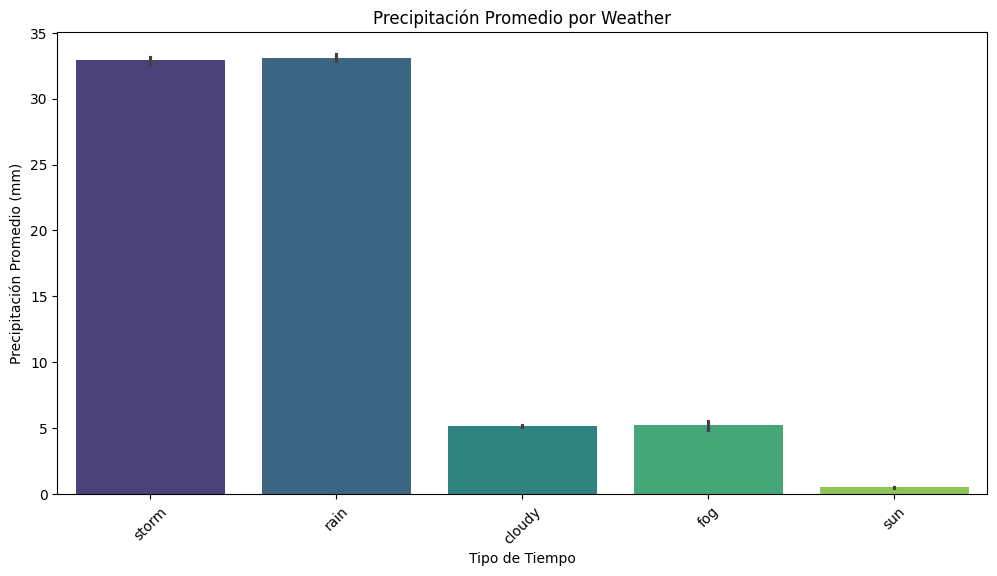

In [47]:
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x='weather', y='precipitation', hue='weather', data=df, palette="viridis", legend=False)
plt.title("Precipitación Promedio por Weather")
plt.xlabel("Tipo de Tiempo")
plt.ylabel("Precipitación Promedio (mm)")
plt.xticks(rotation=45)
plt.show()

TEMPERATURA PROMEDIO POR MES

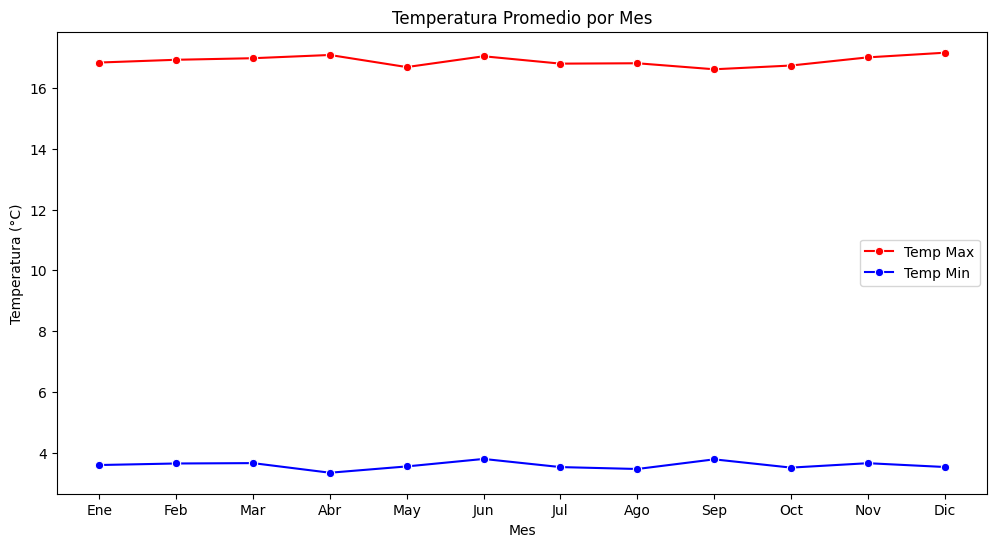

In [48]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('month').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='month', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='month', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Mes")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(ticks=df_temp_by_month['month'], labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.legend()
plt.show()


TEMPERATURA PROMEDIO POR AÑO

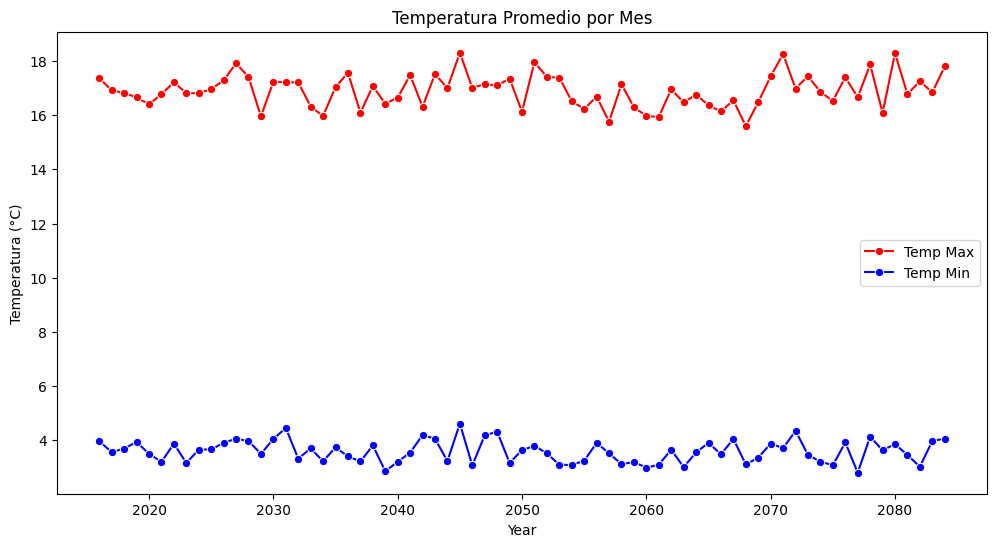

In [ ]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('year').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='year', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='year', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Año")
plt.xlabel("Year")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()


CORRELACIÓN ENTRE CARIABLES METEOROÑLÓGICAS

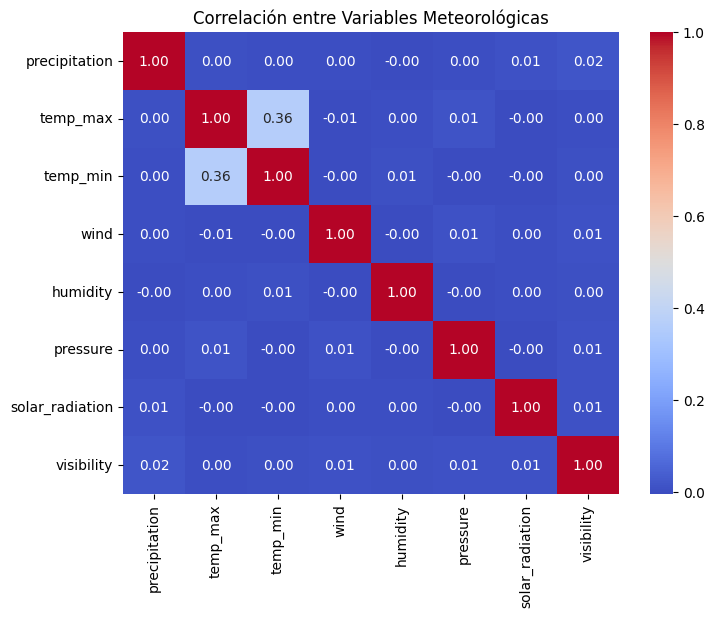

In [61]:
# Selecciona las columnas relevantes para la correlación
correlation_df = df[['precipitation', 'temp_max', 'temp_min', 'wind', 'humidity', 'pressure', 'solar_radiation', 'visibility']]

# Calcula la matriz de correlación
correlation_matrix = correlation_df.corr()

# Grafica la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre Variables Meteorológicas')
plt.show()

VARIABILIDAD DE LA VISIBILIDAD POR CONDICIÓN CLIMÁTICA

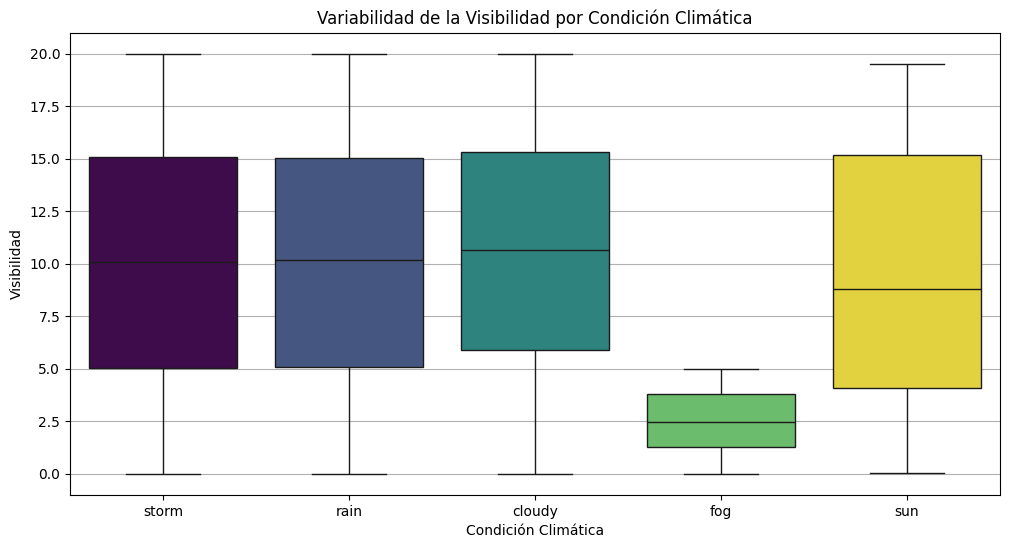

In [68]:
# Grafica de la visibilidad por condición climática
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weather', y='visibility', hue='weather_id', palette="viridis", legend=False)
plt.title('Variabilidad de la Visibilidad por Condición Climática')
plt.xlabel('Condición Climática')
plt.ylabel('Visibilidad')
plt.grid(axis='y')
plt.show()


TEMPERATURA MÁXIMA Y MÍNIMA PROMEDIO POR ESTACIÓN DEL AÑO

<Figure size 1000x600 with 0 Axes>

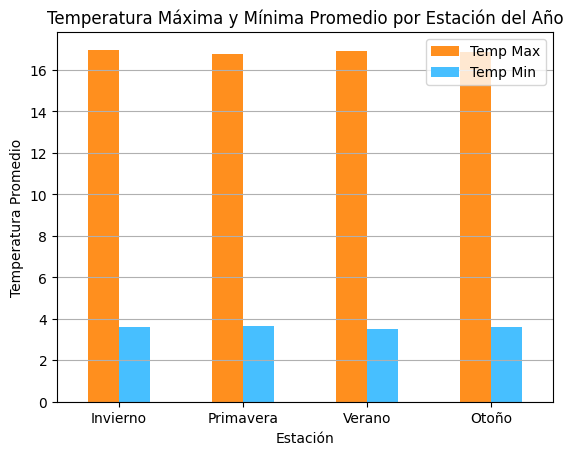

In [73]:
# Temperatura promedio por estación
temp_seasonal_avg = df.groupby('estacion')[['temp_max', 'temp_min']].mean()

# Gráfica de barras para temperatura máxima y mínima por estación
plt.figure(figsize=(10, 6))
temp_seasonal_avg.plot(kind='bar', color=['#ff8f1e','#47bfff'])
plt.title('Temperatura Máxima y Mínima Promedio por Estación del Año')
plt.xlabel('Estación')
plt.xticks(ticks=range(4), labels=['Invierno', 'Primavera', 'Verano', 'Otoño'], rotation=0)
plt.ylabel('Temperatura Promedio')
plt.legend(['Temp Max', 'Temp Min'])
plt.grid(axis='y')
plt.show()
